# Wait Time Analysis

In [1]:
# IMPORT FUNCTIONALITIES
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%load_ext nb_black

<IPython.core.display.Javascript object>

Below, the file containing the candidate properties is read in and the burst times are sorted into an array. This is specified for our file structure and burst fitting procedure, and will likely need to be changed. The endpoints for the histogram bins are also specified. 
We only need the MJDs for this analysis, but pandas is used so one can easily incorporate other burst properties like fluence or DM into the analysis.

In [2]:
# Read in data file
data = pd.read_csv("/home/elewis/FRB121102/all_bursts_bary.csv")
data = data[(data["fit_method"] == "mcmc")]  # excise bursts fit using curvefit
print(str(len(data)) + " good MCMC bursts")

data_flu = data[(data["use_fluence"] == True)]
print(str(len(data_flu)) + " good MCMC/fluence bursts")

# Break into individual MJD array
mjd = data["$\mu_t$ (ms)"]
mjd = mjd.sort_values()

start = np.log10(0.001)
end = np.log10(1000)

130 good MCMC bursts
94 good MCMC/fluence bursts


<IPython.core.display.Javascript object>

In [3]:
# DEFINE FITTING FUNCTIONS
# Log-normal function for WT histogram
def log_fit(x, a, mu, sigma):
    return (
        (a / x)
        * (1.0 / (sigma * np.sqrt(2.0 * np.pi)))
        * np.exp(-((np.log(x) - mu) ** 2.0) / (2.0 * sigma ** 2.0))
    )


# Decaying exponential function to fit to random bursts
def exp_fit(x, a, b, c, d):
    return a * np.exp(-b * x + c) + d

<IPython.core.display.Javascript object>

Below is the function used to create the histogram of burst time differences and fit the wait time distribution. It is assumed that all the bursts come from the same observation, so that the differences are obtained by subtracting consecutive burst times (and converting from MJD to seconds). 
In our analysis, we only fit the distribution to bins with wait times greater than one second. You can change this below.

In [4]:
# Histogram fitting function: needs input of burst times and number of bins


def hist_fit(burst_times, num_bins):
    # Calculate diffs
    diffs = []
    burst_times = np.sort(burst_times)
    for i in range(0, len(burst_times) - 1):
        diffs.append(
            (burst_times[i + 1] - burst_times[i]) * 86400.0
        )  # assuming times are in MJD

    # Make histogram
    bins = np.logspace(start, end, num_bins)
    hist, bin_edges = np.histogram(diffs, bins=bins)

    # Find leftmost bin- only fitting diffs > 1s
    main_bins = np.where(bins > 1.0)
    last_bin = main_bins[0][0]

    # Get bin centers
    ln_data = []
    bin_centers = []
    for i in range(last_bin, len(hist)):
        # Only fitting log-normal to main bulk of distribution, not second distribution of shorter WTs
        ln_data.append(hist[i])
        dist = bin_edges[i + 1] - bin_edges[i]
        halfdist = dist / 2.0
        mid = bin_edges[i] + halfdist
        bin_centers.append(mid)

    # Fit log-normal to bin centers and calculate fit
    mu = 7
    sigma = 1
    a = 1
    popt, pcov = curve_fit(log_fit, bin_centers, ln_data, p0=[a, mu, sigma])
    perr = np.sqrt(np.diag(pcov))
    xaxis = np.logspace(0.5, np.log10(np.max(diffs) * 1.1), 1000)
    yfit = log_fit(xaxis, *popt)

    return bin_centers, ln_data, xaxis, yfit, diffs, bins, perr

<IPython.core.display.Javascript object>

You can change the number of bins used to create the histogram with the num_bins variable below.

In [5]:
# ALL BURSTS
burst_times_all = mjd
num_bins = 18
bin_centers, ln_data, xaxis, yfit, diffs, bins, perr = hist_fit(
    burst_times_all, num_bins
)

max_hist = np.amax(yfit)
max_index = np.where(yfit == max_hist)
wt_peak = np.round(xaxis[max_index][0], 2)
peak_error = np.round(perr[1], 2)

print(
    "Wait time distribution peak:  " + str(wt_peak) + " +/- " + str(peak_error) + " s"
)

Wait time distribution peak:  74.38 +/- 0.11 s


<IPython.core.display.Javascript object>

Below, the analysis to remove random bursts and calculate the wait time is performed.

In [6]:
# Sets up parameters for removal of random number of bursts
ntrials = 150  # number of random trials at each burst number
burstnums = np.linspace(len(data) - 80, len(data), num=17)
print(burstnums)

[ 50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100. 105. 110. 115.
 120. 125. 130.]


<IPython.core.display.Javascript object>

In [7]:
# REMOVING RANDOM BURSTS- TRIALS

all_meanpeaks = []
all_stdvs = []

for num in burstnums:
    random_peaks = []  # array that holds all WT peaks at each burst number

    for j in range(0, ntrials):
        # make DF with random bursts removed
        num = int(num)
        rand_rmvd_data = data.sample(n=num, random_state=j)
        mjds_rand = rand_rmvd_data["$\mu_t$ (ms)"]

        # Fit histogram and get wait time peak
        (
            bin_centers_rand,
            ln_data_rand,
            xaxis_rand,
            yfit_rand,
            diffs_rand,
            bins_rand,
            perr_rand,
        ) = hist_fit(mjds_rand, num_bins)
        max_hist_rand = np.amax(yfit_rand)
        max_index_rand = np.where(yfit_rand == max_hist_rand)
        wtpeak = xaxis_rand[max_index_rand]
        random_peaks.append(wtpeak)

    meanpeak = np.mean(random_peaks)
    stdpeak = np.std(random_peaks)
    print(
        "N = "
        + str(num)
        + ", mean peak = "
        + str(np.round(meanpeak, 2))
        + ", stdev = "
        + str(np.round(stdpeak, 2))
    )
    all_meanpeaks.append(meanpeak)
    all_stdvs.append(stdpeak)

N = 50, mean peak = 185.65, stdev = 42.21
N = 55, mean peak = 163.07, stdev = 28.87
N = 60, mean peak = 146.5, stdev = 22.05
N = 65, mean peak = 134.52, stdev = 17.35
N = 70, mean peak = 125.01, stdev = 14.75
N = 75, mean peak = 117.6, stdev = 11.99
N = 80, mean peak = 110.64, stdev = 10.31
N = 85, mean peak = 104.47, stdev = 8.54
N = 90, mean peak = 99.36, stdev = 7.83
N = 95, mean peak = 95.48, stdev = 6.69
N = 100, mean peak = 91.75, stdev = 5.95
N = 105, mean peak = 87.83, stdev = 4.96
N = 110, mean peak = 84.8, stdev = 4.12
N = 115, mean peak = 81.85, stdev = 3.61
N = 120, mean peak = 79.36, stdev = 2.98
N = 125, mean peak = 77.05, stdev = 2.14
N = 130, mean peak = 74.38, stdev = 0.0


<IPython.core.display.Javascript object>

Timescale = 28.9 +/- 1.4 s


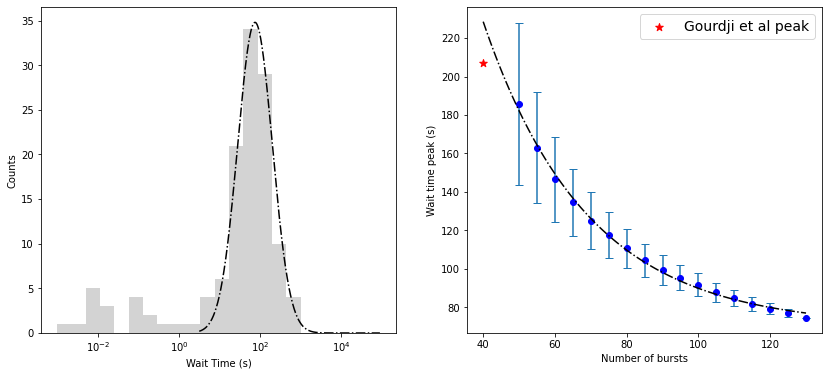

<IPython.core.display.Javascript object>

In [17]:
# PLOT
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# ax.plot(bin_centers, ln_data, 'ro')  #plots bin centers used to fit histogram, as a check
ax[0].plot(xaxis, yfit, "k-.")
ax[0].set_xscale("log")
ax[0].hist(diffs, bins=bins, color="lightgray")
# ax.vlines(x=xaxis[max_index], ymin=0, ymax=max_hist+2, linestyles='dashed') #plots vertical line at WT peak
ax[0].set_xlabel("Wait Time (s)")
ax[0].set_ylabel("Counts")


# Exponential fit
A = 0.01
B = 0.01
C = 50
D = 5
exppopt, exppcov = curve_fit(exp_fit, burstnums, all_meanpeaks, p0=[A, B, C, D])
expperr = np.sqrt(np.diag(exppcov))
b = exppopt[1]
b_err = expperr[1]
ts = 1.0 / b
ts_err = b_err / (b ** 2)
print("Timescale = " + str(np.round(ts, 1)) + " +/- " + str(np.round(ts_err, 1)) + " s")

xaxis_rand = np.linspace(40, burstnums[-1], num=100)
yfit_rand = exp_fit(xaxis_rand, *exppopt)
ax[1].plot(xaxis_rand, yfit_rand, "k-.")
ax[1].scatter(40, 207, s=64, color="r", marker="*", label="Gourdji et al peak")
ax[1].errorbar(burstnums, all_meanpeaks, yerr=all_stdvs, capsize=4, linestyle="")
ax[1].plot(burstnums, all_meanpeaks, "bo", linestyle="")
ax[1].legend(fontsize=14)
ax[1].set_xlabel("Number of bursts")
ax[1].set_ylabel("Wait time peak (s)")
plt.show()